## IMPLEMENTING A GPT MODEL FROM SCRATCH TO GENERATE TEXT

In [1]:
GPT_CONFIG_124M = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,  # Embedding dimension
    "n_heads": 12,   # Number of attention heads
    "n_layers":12,   # Number of layers
    "drop_rate": 0.1, # Dropout rate
    "qkv_bias": False  # Query-Key-Value bias
}



## GPT ARCHITECTURE PART 1 : DUMMY GPT MODEL CLASS

<div class="alert alert-block alert-info"> 
Step 1: Use a placeholder for Transformer Block

Step 2: Use a placeholder for LayerNorm
</div>



In [2]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for Transformer Block

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"]) ]
        )

        # Use a placeholdr for LayerNorm
        
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )


        

    def forward(self,in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    



class DummyTransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        # A simple placeholder

    def forward(self,x):
        # This block does nothing and just returns its input.
        return x 
    

class DummyLayerNorm(nn.Module):
    def __init__(self,normalized_shape,eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self,x):
        # This  layer does nothing and  just returns its input.
        return x 
    



In [3]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every efforts moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch,dim=0)
print(batch)


tensor([[6109, 4040, 6100,  345],
        [6109, 1110, 6622,  257]])


## STEP 2 : CREATE AN INSTANCE OF  GPT MODEL

In [4]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:",logits.shape)
print(logits)

NameError: name 'GPTModel' is not defined

## GPT ARCHITECTURE PART 2 : LAYER NORMALIZATON

#### Explanation with a simple example

In [82]:
torch.manual_seed(123)
batch_example = torch.randn(2,5) #A
layer = nn.Sequential(nn.Linear(5,6),nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


: 

: 

<div class="alert alert-block alert-info">
The neural network layer we have coded consists of a Linear layer followed by a non-linear activation function (RELU). 
 </div>



<div class="alert alert-block alert-success">
Before we apply layer normalization to these outputs, let's examine the mean and variance:
 </div>



In [83]:
mean = out.mean(dim=-1,keepdim=True)
var = out.var(dim=-1,keepdim=True)
print("Mean:\n",mean)
print("Variance:\n",var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


: 

: 

<div class="alert alert-block alert-warning">
The first row in the mean tensor above contains the mean value for the first input row, and the second output row contains the mean for the second input row.
 </div>



In [84]:
out_norm = ( out - mean)/ torch.sqrt(var)
mean = out_norm.mean(dim=-1,keepdim=True)
var = out_norm.var(dim=-1,keepdim=True)
print("Normalized layer outputts:\n",out_norm)
print("Mean:\n",mean)
print("Variance:\n",var)

Normalized layer outputts:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


: 

: 

In [85]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n",mean)
print("Variance:\n",var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


: 

: 

In [86]:
# LayerNorm implementation
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

: 

: 

<div class="alert alert-block alert-success">
Let's now try the LayerNorm module in practice and apply it to the batch input:
</div>

In [87]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1,keepdim=True)
var = out_ln.var(dim=-1,unbiased=False,keepdim=True)
print("Mean:\n",mean)
print("Variance:\n",var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


: 

: 

## ARCHITECTURE PART 3 : FEEDFORWARD NEURAL NETWORK WITH GELU ACTIVATION

<div class="alert alert-block alert-success">
Let's implement the GELU activation function approximation used by GPT-2:
</div>

In [88]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return 0.5*x*(1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi))*
            (x+ 0.044715*torch.pow(x,3))
        ))

: 

: 

<div class="alert alert-block alert-success">
To get an idea of what this  GELU function looks like and how it compares to the ReLu function, let's plot these functions side by side:
</div>

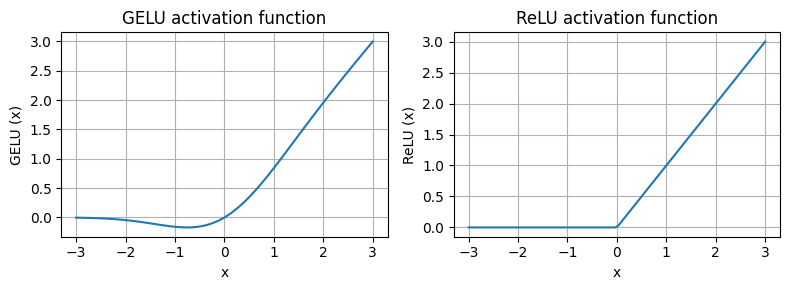

: 

: 

In [89]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3,3,100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8,3))
for i, (y,label) in enumerate(zip([y_gelu,y_relu],['GELU',"ReLU"]),1):
    plt.subplot(1,2,i)
    plt.plot(x,y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label} (x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


In [90]:
class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"],4* cfg["emb_dim"]), ## Expansion
            GELU(),  ## Activation
            nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]), ## Contraction
        )

    def forward(self,x):
        return self.layers(x)

: 

: 

In [91]:
print(GPT_CONFIG_124M["emb_dim"])

768


: 

: 

In [92]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2,3,768) #A
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


: 

: 

## GPT ARCHITECTURE PART 4: SHORTCUT CONNECTIONS

<div class="alert alert-block alert-success">
Let us see how we can add shortcut connections to the forward method:
</div>

In [93]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self,layer_sizes,use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList(
            [
                nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]),GELU()),
                nn.Sequential(nn.Linear(layer_sizes[1],layer_sizes[2]),GELU()),
                nn.Sequential(nn.Linear(layer_sizes[2],layer_sizes[3]),GELU()),
                nn.Sequential(nn.Linear(layer_sizes[3],layer_sizes[4]),GELU()),
                nn.Sequential(nn.Linear(layer_sizes[4],layer_sizes[5]),GELU()),

            ]
        )

    def forward(self,x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output  = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x



: 

: 

In [94]:
layer_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.,0.,-1.]])
torch.manual_seed(123) # specify random seed for the initial weights 
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes,use_shortcut=False
)

: 

: 

<div class="alert alert-block alert-success">
Next, we implement a function that computes the gradients in the model's backward pass:
</div>

In [95]:
def print_gradients(model,x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calcuate loss based on how close the target  and output are
    loss = nn.MSELoss()
    loss = loss(output,target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if "weight" in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
            


: 

: 

In [96]:
print_gradients(model_without_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.00020173590746708214
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152042235247791
layers.3.0.weight has gradient mean of 0.0013988739810883999
layers.4.0.weight has gradient mean of 0.00504964729771018


: 

: 

<div class="alert alert-block alert-success">
Let's now instantiate a model with skip connections and see how it comparees:
</div>

In [97]:
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes,use_shortcut=True 
)
print_gradients(model_without_shortcut,sample_input)

layers.0.0.weight has gradient mean of 0.22169791162014008
layers.1.0.weight has gradient mean of 0.20694102346897125
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472


: 

: 

## GPT ARCHITECTURE  PART 5: CODING ATTENTION AND LINEAR LAYERS IN A TRANSFORMER BLOCK

In [98]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,      # Vocabulary size
    "context_length": 1024,   # Context length
    "emb_dim": 768,           # Embedding dimension
    "n_heads": 12,            # Number of attention heads
    "n_layers": 12,           # Number of layers
    "drop_rate": 0.1,         # Dropout rate
    "qkv_bias": False         # Query-Key-Value bias
}

: 

: 

### THE BUILDING BLOCKS: LAYER NORMALIZATION, GELU AND FEED-FORWARD NEURALNETWORK

In [99]:
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True,unbiased=False)
        norm_x = (x - mean)/ torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift



class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return 0.5*x*(1+torch.tanh(
            torch.sqrt(torch.tensor(2.0/torch.pi))*
            (x + 0.044715*torch.pow(x,3))

        ))

class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]), ## Contraction
        )

    def forward(self,x):
        return self.layers(x)

: 

: 

<div class="alert alert-block alert-success">
Let us code a transformer block as follows:
 </div>

<div class="alert alert-block alert-info">

Step 1: Shortcut connection for attention block

Step 2: Shortcut connectin for feed forward block

Step 3: Add the original input block

 </div>

In [115]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, num_heads, dropout, qkv_bias=True):
        super().__init__()
        self.num_heads = num_heads
        self.d_head = d_out // num_heads
        self.scale = self.d_head ** -0.5  # Scaling factor for attention scores

        self.q_proj = nn.Linear(d_in, d_out, bias=qkv_bias)  # Query projection
        self.k_proj = nn.Linear(d_in, d_out, bias=qkv_bias)  # Key projection
        self.v_proj = nn.Linear(d_in, d_out, bias=qkv_bias)  # Value projection
        self.out_proj = nn.Linear(d_out, d_out)  # Output projection

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, context=None, mask=None):
        # If no context is provided, self-attention is performed
        context = x if context is None else context

        # Compute Query, Key, and Value matrices
        Q = self.q_proj(x)  # [batch_size, seq_len, d_out]
        K = self.k_proj(context)  # [batch_size, seq_len, d_out]
        V = self.v_proj(context)  # [batch_size, seq_len, d_out]

        # Reshape for multi-head attention
        Q = Q.view(Q.shape[0], Q.shape[1], self.num_heads, self.d_head).transpose(1, 2)
        K = K.view(K.shape[0], K.shape[1], self.num_heads, self.d_head).transpose(1, 2)
        V = V.view(V.shape[0], V.shape[1], self.num_heads, self.d_head).transpose(1, 2)

        # Compute scaled dot-product attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Compute the attention output
        attn_output = torch.matmul(attn_weights, V)  # [batch_size, num_heads, seq_len, d_head]

        # Reshape back to original dimensions
        attn_output = attn_output.transpose(1, 2).contiguous().view(x.shape[0], x.shape[1], -1)

        # Apply the output projection
        output = self.out_proj(attn_output)
        return output


In [117]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length= cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self,x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shpae [batch_size, num_tokens,emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut # Add the original input back

        # Shortcut connectin for feed forward block

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut # Add the original input back

        return x 


<div class="alert alert-block alert-warning">
The given code defines a TransformerBlock class in PyTorch that includes a multi-head attention mechanism (MultiHeadAttention) and a feed forward network (FeedForward), both configured based on a provided configuration dictionary (cfg), such as GPT_CONFIG_124M.
 </div>

<div class="alert alert-block alert-success">
Using the GPT_CONFIG_124M dictionary we defined earlier, let's instantiate a transformer block and feed it some sample data
 </div>

<div class="alert alert-block alert-info">
Create sample input of shape [batch_size,num_tokens,emb_dim]
 </div>

In [101]:
# torch.manual_seed(123)
# x = torch.rand(2,4,768) #A
# block = TransformerBlock(GPT_CONFIG_124M)
# output = block(x)
# print("Input shape:",x.shape)
# print("Output shape:",output.shape)

: 

: 

### GPT ARCHITECTURE PART 6: ENTIRE GPT MODEL ARCHITECTURE IMPLEMENTION

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,       # Vocabulary size
    "context_length": 1024,    # Context length
    "emb_dim": 768,            # Embedding dimension
    "n_heads": 12,             # Number of attention heads
    "n_layers": 12,            # Number of layers
    "drop_rate": 0.1,          # Dropout rate
    "qkv_bias": False          # Query-Key-Value bias
}


<div class="alert alert-block alert-success">
We started with this: A dummy GPT model class
<div/>

In [103]:
import torch
import torch.nn as nn

class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_block = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]

        )

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"],cfg["vocab_size"],bias = False
        )

    def forward(self,in_idx):
        batch_size,seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device))
        x = tok_embeds + pos_embeds # Shape [ batch_size,num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_block(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

: 

: 

In [104]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n",batch)
print("\nOutput shape:",out.shape)
print(out)

Input batch:
 tensor([[6109, 4040, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.8606,  1.3502, -0.2798,  ..., -0.6376,  1.4690,  1.2530],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


: 

: 

In [105]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number o parameters: {total_params}")


Total number o parameters: 77981184


: 

: 

In [106]:
print("Token embedding layer shape:",model.tok_emb.weight.shape)
print("Output layer shape:",model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


: 

: 

<div class="alert alert-block alert-success">
Lastly, let us compute the memory requiremetns of the 163 million parameters in our GPTModel object:
<div/>

In [107]:
total_size_bytes = total_params*4 #A
total_size_mb = total_size_bytes / (1024*1024) #B
print(f"Total size of the model:{total_size_mb:.2f} MB")

Total size of the model:297.47 MB


: 

: 

## GPT ARCHITECTURE PART 7: GENERATING TEXT FROM OUTPUT TOKENS

<div class="alert alert-block alert-success">
Let us implement the token-generatin process as follows:
<div/>

<div class="alert alert-block alert-info">

**Step 1:** `idx` is a `(batch, n_tokens)` array of indices in the current context.

**Step 2:** Crop current context if it exceeds the supported context size.  
E.g., if LLM supports only 5 tokens, and the context size is 10, then only the last 5 tokens are used as context.

**Step 3:** Focus only on the last time step, so that `(batch, n_token, vocab_size)` becomes `(batch, vocab_size)`.

**Step 4:** `probas` has shape `(batch, vocab_size)`.

**Step 5:** `idx_next` has shape `(batch, 1)`.

**Step 6:** Append sampled index to the running sequence, where `idx` has shape `(batch, n_tokens+1)`.


<div/>

In [108]:
def generate_text_simple(model,idx,max_new_tokens, context_size):
    # idx is (batch,n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size 
        # E.g, if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:,-context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        # (batch,n_tokens,vocab_size) becomes (batch,vocab_size)
        logits  = logits[:,-1,:]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits,dim=-1) # (batch,vocab_size)

        # Get the idx of the vocab entry with the hightest probability value
        idx_next = torch.argmax(probas,dim=-1,keepdim=True) #(batch,1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx,idx_next),dim=-1) # (batch,n_tokens+1)

    return idx 


: 

: 

In [109]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)

print("encoded:",encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #A
print("encoded_tensor.shape:",encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


: 

: 

In [110]:
model.eval() # A
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]


)
print("Output:",out)
print("Output length:",len(out[0]))

Output: tensor([[15496,    11,   314,   716, 12170, 44251, 25952, 49216, 30322,  6868]])
Output length: 10


: 

: 

In [111]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am drone Omni SSLmyra muc native


: 

: 

<div class="alert alert-block alert-info">
As we can see, based on the preceding output, the model generated gibberish, which is not at all coherent text.

What happened?

The reason why the model is unable to produce coherent text is that we haven't trained it yet.

So far, we just implemented the GPT architecture and initialized a GPT model instance with initial random weights.
<div/>

In [112]:
# Input token sequences
inputs = torch.tensor([
    [16833, 3626, 6100],  # ["every effort moves"]
    [40, 1107, 588]       # ["I really like"]
])

# Target token sequences
targets = torch.tensor([
    [3626, 6100, 345],    # ["effort moves you"]
    [1107, 588, 1131]     # ["really like chocolate"]
])

: 

: 

In [113]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits,dim=-1) # Probability of each token in vocab
print(probas.shape)  # Shpae: (batch_size,num_tokens,vocab_size)



torch.Size([2, 3, 50257])


: 

: 

In [114]:
token_ids=torch.argmax(probas,dim=-1,keepdim=True)
print("Toekn IDs:\n",token_ids)

Toekn IDs:
 tensor([[[25388],
         [41068],
         [49272]],

        [[ 2109],
         [ 3957],
         [30269]]])


: 

: 

In [115]:
import tiktoken
import torch

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


Output text:
 Every effort moves you horizontRoomki laserutfucks Levels Nice Sir dentist


: 

: 

<div class="alert alert-block alert-success">
We use a relatively small dataset for training the LLM (in fact, only one short story)

The reasons are:

You can run the code examples in a few minutes on a laptop computer without a suitable GPU.

The training finishes relatively fast (minutes instead of weeks), which is good for educational purposes.
We use a text from the public domain, which can be included in this GitHub repository without violating any usage rights.
For example, Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens.
At the time of this writing, the hourly cost of an 8xA100 cloud server at AWS is approximately 30 dollars.
So, via an off-the-envelope calculation, training this LLM would cost 184,320 / 8 * 30 = 690,000 dollars.
<div/>

In [116]:
import os 


file_path = "text_data/the-verdict.txt"



if  os.path.exists(file_path):

    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()


: 

: 

<div class="alert alert-block alert-success">
A   quick check that the text loaded ok by printing the first and last 100 words
<div/>

In [117]:
# First 100 words of the text
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


: 

: 

In [118]:
# Last 100 words of the text

: 

: 

In [119]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

: 

: 

In [120]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))


print("Characters:",total_characters)
print("Tokens::",total_tokens)

Characters: 20479
Tokens:: 5145


: 

: 

<div class="alert alert-block alert-success">
With 5,145 tokens, the text is very short for training an LLM, but again, it's for educational purposes.
Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2.

Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position.
<div/>

## IMPLEMENTING THE DATALOADER 

In [121]:
from torch.utils.data import Dataset,DataLoader

class GPTDatasetV1(Dataset):
    def __init__(self,txt,tokenizer,max_length,stride):
        self.input_ids = []
        self.target_ids = []


        # Tokenize the entire text
        token_ids = tokenizer.encode(txt,allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length

        for i in range(0,len(token_ids) - max_length,stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))


    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

: 

: 

In [122]:
def create_dataloader_v1(txt,batch_size=4,max_length=256,stride=128,shuffle=True, drop_last=True,num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    #Create dataset
    dataset = GPTDatasetV1(txt,tokenizer,max_length,stride)

    #Create dataloader
    dataloader =  DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    ) 

    return dataloader


    

: 

: 

In [108]:
class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_block = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]

        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); # Disaable dropout during inference


NameError: name 'TransformerBlock' is not defined

In [123]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,       # Vocabulary size
    "context_length": 256,     # Shortened context length (orig: 1024)
    "emb_dim": 768,            # Embedding dimension
    "n_heads": 12,             # Number of attention heads
    "n_layers": 12,            # Number of layers
    "drop_rate": 0.1,          # Dropout rate
    "qkv_bias": False          # Query-key-value bias
}

: 

: 

In [124]:
# Train/validation ratio
train_ratio = 0.90

split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)


: 

: 

In [125]:
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)


: 

: 

In [126]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1 - train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")


: 

: 

<div class="alert alert-block alert-success">
An optional check that the data was loaded correctly:
<div/>

In [127]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))


Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9


: 

: 

In [128]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)


Training tokens: 4608
Validation tokens: 512
All tokens: 5120


: 

: 

# Here is the GPT Model class we coded earlier. We will need this

In [129]:


class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        # Ensure d_out is divisible by num_heads
        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Projection dimension per head
        
        # Linear layers for Query, Key, and Value
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        # Output projection layer
        self.out_proj = nn.Linear(d_out, d_out)  # Combine outputs from all heads
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Register a causal mask for self-attention
        self.register_buffer(
            "mask", 
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        # Input shape: (batch_size, num_tokens, d_in)
        b, num_tokens, d_in = x.shape
        
        # Project to Query, Key, Value
        keys = self.W_key(x)    # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        # Reshape for multi-head processing
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)  # Shape: (b, num_heads, num_tokens, head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Compute scaled dot-product attention
        attn_scores = queries @ keys.transpose(2, 3)  # Shape: (b, num_heads, num_tokens, num_tokens)
        
        # Apply causal mask
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]  # Adjust mask size to current context
        attn_scores.masked_fill_(mask_bool, -torch.inf)  # Fill masked positions with -inf
        
        # Compute attention weights
        attn_weights = torch.softmax(attn_scores / (keys.shape[-1] ** 0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)  # Apply dropout
        
        # Compute context vectors
        context_vec = (attn_weights @ values).transpose(1, 2)  # Shape: (b, num_tokens, num_heads, head_dim)
        
        # Combine heads
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # Final projection
        
        return context_vec


: 

: 

<div class="alert alert-block alert-success">
Next, we implement a utility function to calculate the cross-entropy loss of a given batch.

In addition, we implement a second utility function to compute the loss for a user-specified number of batches
<div/>

In [131]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


: 

: 

: 

: 

In [136]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

: 

: 

In [138]:
# model.to(device)

# torch.manual_seed(123)

# with torch.no_grad():
#     train_loss = calc_loss_loader(train_loader,model,device)
#     val_loss = calc_loss_loader(val_loader,model,device)

# print("Training loss:",train_loss)
# print("Validation loss:",val_loss)


: 

: 

In [6]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()


: 

: 

In [7]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


: 

: 

In [9]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)  # Calculate loss
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()  # Returns the total number of elements (or tokens) in the batch
            global_step += 1

                # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

            # Print a sample text after each epoch
        generate_and_print_sample(
                            model, tokenizer, device, start_context
                        )
    return train_losses,val_losses,track_tokens_seen




: 

: 

<div class="alert alert-block alert-info">

**Steps for Training the Model:**
1. **Initialize lists to track losses and tokens seen**
2. **Start the main training loop**
3. **Reset loss gradients from previous batch iteration**
4. **Calculate loss gradients**
5. **Update model weights using loss gradients**
6. **Optional evaluation step**
7. **Print a sample text after each epoch**

<div/>

In [123]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(), lr=0.0004, weight_decay=0.1
)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")


TypeError: __init__() got an unexpected keyword argument 'context_length'

## DECODING STRRATEGIES TO CONTROL RANDOMENESS

In [130]:
# model.to("cpu")
# model.eval()

In [8]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}


In [9]:
inverse_vocab 


{0: 'closer',
 1: 'every',
 2: 'effort',
 3: 'forward',
 4: 'inches',
 5: 'moves',
 6: 'pizza',
 7: 'toward',
 8: 'you'}

In [10]:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)


In [11]:
probas = torch.softmax(next_token_logits, dim=0)

print(probas)

next_token_id = torch.argmax(probas).item()

print(next_token_id)

print(inverse_vocab[next_token_id])


tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
3
forward


In [12]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas,num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [13]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)  # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)


71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


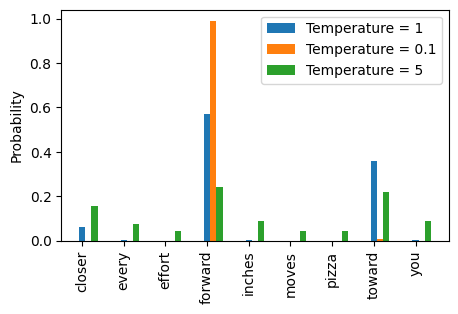

In [15]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()


## DECODING STRATEGY 2 TOP-K SAMPLING 

In [17]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits,top_k)
print("Top logits:", top_logits)
print("Top positions:",top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [18]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input = torch.tensor(float("-inf")),
    other=next_token_logits
)

In [19]:
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


<div class="alert alert-block alert-success">
Lastly, let's apply the softmax function to turn these into next-token probabilities:
<div/>

In [20]:
topk_probas = torch.softmax(new_logits,dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## Merge Temperature Scaling and Top-K sampling 

<div class="alert alert-block alert-success">
## Steps for Sequence Generation with Temperature and Top-K Sampling

1. **For-loop is the same as before**: 
   - Get logits from the model.
   - Focus only on the logits of the last time step.

2. **Filter logits with Top-K Sampling**:
   - Retain only the top `k` logits while setting others to a very low value (e.g., `-inf`) to focus on the most probable tokens.

3. **Apply Temperature Scaling**:
   - Scale the logits by dividing them with the specified temperature value.
   - Use the softmax function to convert scaled logits into probabilities.

4. **Carry out Greedy Next-Token Selection**:
   - Select the token with the highest probability after applying temperature scaling if no sampling is performed.

5. **Stop Early for End-of-Sequence Token**:
   - If the `eos_id` (end-of-sequence token ID) is encountered during generation, terminate the sequence generation early.
   <div/>


In [28]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
            logits = logits[:, -1, :]  # Focus on the last time step

        # Top-K Sampling
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val, 
                torch.tensor(float("-inf")).to(logits.device), 
                logits
            )

        # Temperature Scaling
        if temperature > 0.0:
            logits = logits / temperature

        # Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=-1)

        # Sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Stop generating early if end-of-sequence token is encountered
        if eos_id is not None and idx_next.item() == eos_id:
            break

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx


In [27]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M['context_length'],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


NameError: name 'model' is not defined